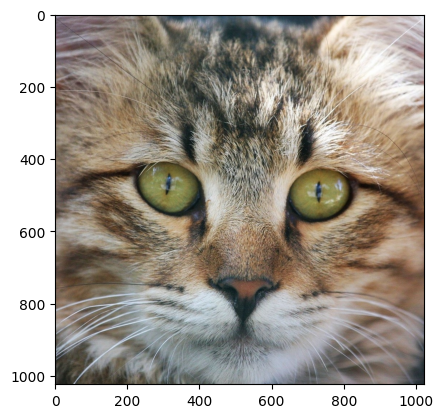

In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import lovely_tensors as lt
import os
import imageio.v2 as imageio
import numpy as np
import torch
lt.monkey_patch()
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Download image, take a square crop from the center
image_url = 'https://wallpaperfx.com/view_image/american-bobtail-cat-face-1024x1024-wallpaper-17750.jpg'
img = imageio.imread(image_url)[..., :3]
plt.imshow(img)
plt.show()

Shape of xy: torch.Size([64, 2])
First few values of xy:
 tensor[5, 2] n=10 x∈[0.007, 0.975] μ=0.408 σ=0.324 [[0.763, 0.517], [0.007, 0.148], [0.136, 0.709], [0.274, 0.411], [0.138, 0.975]]

Shape of rgb: torch.Size([64, 3])
First few values of rgb:
 tensor[5, 3] n=15 x∈[0.153, 0.537] μ=0.340 σ=0.131


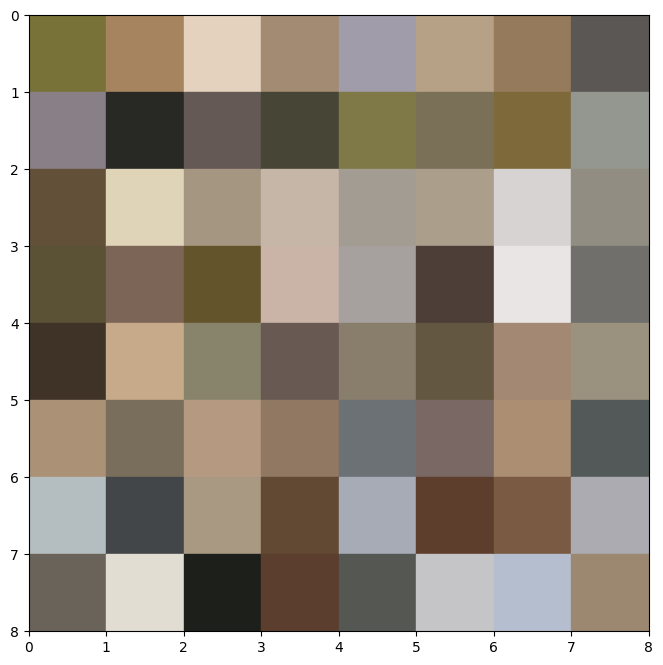

In [2]:
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, img):
        h, w, c = img.shape
        # Create a meshgrid of positions
        x = np.linspace(0, 1, w)
        y = np.linspace(0, 1, h)
        xv, yv = np.meshgrid(x, y)
        positions = np.stack((xv, yv), axis=-1)

        self.X = torch.from_numpy(positions.reshape(-1, 2)).float()  # shape (h*w, 2)
        self.Y = torch.from_numpy(img.reshape(-1, c)).float() / 255.0  # Normalize to [0, 1] range, shape (h*w, 3)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.Y[idx, :]


dataset = CustomImageDataset(img)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
xy, rgb = next(iter(loader))
xy, rgb
print("Shape of xy:", xy.shape)
print("First few values of xy:\n", xy[:5])

print("\nShape of rgb:", rgb.shape)
print("First few values of rgb:\n", rgb[:5])
plt.figure(figsize=(8,8))
for i in range(8):
    for j in range(8):
        plt.fill([i, i+1, i+1, i], [j, j, j+1, j+1], color=rgb[8*i + j].numpy())  # divide by 255 to bring colors to [0, 1] range
plt.xlim(0, 8)
plt.ylim(0, 8)
plt.gca().invert_yaxis()  # invert y-axis to align with image coordinates
plt.show()


Epoch 100/1000, Loss: 0.31943467259407043, PSNR: 4.956179141998291
Epoch 200/1000, Loss: 0.08122321218252182, PSNR: 10.9031982421875
Epoch 300/1000, Loss: 0.02091831900179386, PSNR: 16.79473114013672
Epoch 400/1000, Loss: 0.0053948708809912205, PSNR: 22.68018913269043
Epoch 500/1000, Loss: 0.0013869223184883595, PSNR: 28.579479217529297
Epoch 600/1000, Loss: 0.0003544303181115538, PSNR: 34.50469207763672
Epoch 700/1000, Loss: 8.978578262031078e-05, PSNR: 40.467926025390625
Epoch 800/1000, Loss: 2.246695657959208e-05, PSNR: 46.48455810546875
Epoch 900/1000, Loss: 5.528483598027378e-06, PSNR: 52.573936462402344
Epoch 1000/1000, Loss: 1.330850864178501e-06, PSNR: 58.758705139160156


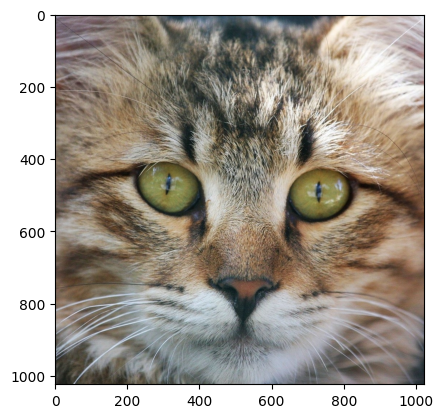

In [3]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Function to calculate Peak Signal-to-Noise Ratio (PSNR)
def psnr(original, reconstructed):
    mse = torch.mean((original - reconstructed) ** 2)
    max_pixel = 1.0  # Assuming the pixel range of the image is [0, 1]
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr

# Load the original image
original_image = img

# Preprocess the original image and convert it to a PyTorch tensor
preprocess = transforms.ToTensor()
original_tensor = preprocess(original_image).unsqueeze(0)

# Create a randomly initialized tensor for image reconstruction
reconstructed_tensor = torch.randn(original_tensor.size(), requires_grad=True)

# Define the Mean Squared Error (MSE) loss
criterion = torch.nn.MSELoss()

# Create an Adam optimizer for optimizing the reconstructed tensor
optimizer = optim.Adam([reconstructed_tensor], lr=0.01)

# Number of training epochs
num_epochs = 1000

# Lists to store losses and PSNR values
losses = []
psnr_values = []

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Calculate the loss between the reconstructed tensor and the original tensor
    loss = criterion(reconstructed_tensor, original_tensor)

    # Calculate PSNR and save it
    with torch.no_grad():
        psnr_value = psnr(original_tensor, reconstructed_tensor)
    psnr_values.append(psnr_value.item())

    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    # Save the loss value
    losses.append(loss.item())

    # Print the loss and PSNR
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, PSNR: {psnr_value.item()}")

# Convert the reconstructed tensor to an image
reconstructed_image = transforms.ToPILImage()(reconstructed_tensor.squeeze())
plt.imshow(reconstructed_image)
plt.show()

CNN 

Epoch 10/1000, Loss: 0.019534440711140633, PSNR: 17.09199018508434
Epoch 20/1000, Loss: 0.0037757738027721643, PSNR: 24.229940310981096
Epoch 30/1000, Loss: 0.003736034967005253, PSNR: 24.275890676918472
Epoch 40/1000, Loss: 0.002296751830726862, PSNR: 26.38885928779093
Epoch 50/1000, Loss: 0.0018238177290186286, PSNR: 27.390185669049977
Epoch 60/1000, Loss: 0.0014294820139184594, PSNR: 28.44821304667731
Epoch 70/1000, Loss: 0.0009127960074692965, PSNR: 30.3962626817118
Epoch 80/1000, Loss: 0.0006766965962015092, PSNR: 31.69606008021659
Epoch 90/1000, Loss: 0.0005609492654912174, PSNR: 32.51076416308162
Epoch 100/1000, Loss: 0.00047987792640924454, PSNR: 33.188692264358586
Epoch 110/1000, Loss: 0.0004288741620257497, PSNR: 33.67670117499917
Epoch 120/1000, Loss: 0.000393059104681015, PSNR: 34.05542139429157
Epoch 130/1000, Loss: 0.00036228299723006785, PSNR: 34.409520479208446
Epoch 140/1000, Loss: 0.0003356861125212163, PSNR: 34.74066625329763
Epoch 150/1000, Loss: 0.00031165557447820

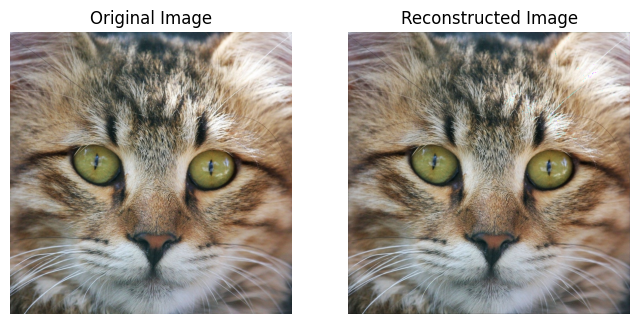

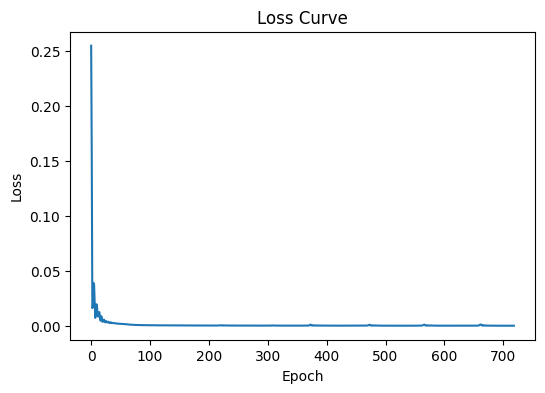

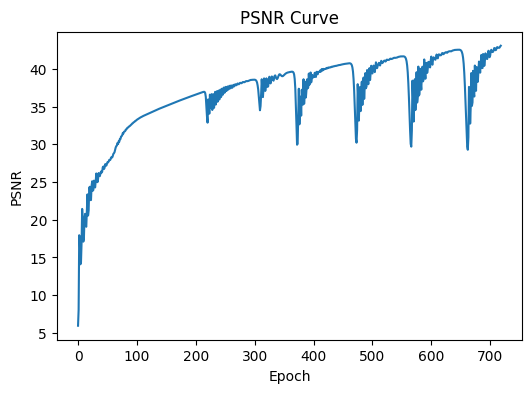

In [4]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import math

# Load the original image
preprocess = transforms.ToTensor()
original_tensor = preprocess(original_image).unsqueeze(0)

# Define the neural network model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.conv2(x)
        return x

# Initialize the neural network model and optimizer
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()
num_epochs = 1000
losses = []
psnr_values = []

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass and compute the loss
    reconstructed_tensor = model(original_tensor)
    loss = criterion(reconstructed_tensor, original_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Save the loss value
    losses.append(loss.item())

    # Calculate PSNR
    mse = loss.item()
    psnr = 10 * math.log10(1 / mse)
    psnr_values.append(psnr)

    # Print the loss and PSNR
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, PSNR: {psnr}")
    
    if psnr>43:
        break

# Convert the reconstructed tensor to an image
reconstructed_image = transforms.ToPILImage()(reconstructed_tensor.squeeze())

# Display the original image and reconstructed image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image)
plt.axis("off")

# Display the loss curve
plt.figure(figsize=(6, 4))
plt.title("Loss Curve")
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Display the PSNR curve
plt.figure(figsize=(6, 4))
plt.title("PSNR Curve")
plt.plot(psnr_values)
plt.xlabel("Epoch")
plt.ylabel("PSNR")

plt.show()

## Question 2

Epoch 100/30000, Loss: 18759.1796875
Epoch 200/30000, Loss: 18505.4296875
Epoch 300/30000, Loss: 18254.56640625
Epoch 400/30000, Loss: 18006.544921875
Epoch 500/30000, Loss: 17761.30859375
Epoch 600/30000, Loss: 17518.8125
Epoch 700/30000, Loss: 17279.00390625
Epoch 800/30000, Loss: 17041.83984375
Epoch 900/30000, Loss: 16807.271484375
Epoch 1000/30000, Loss: 16575.255859375
Epoch 1100/30000, Loss: 16345.751953125
Epoch 1200/30000, Loss: 16118.7197265625
Epoch 1300/30000, Loss: 15894.1201171875
Epoch 1400/30000, Loss: 15671.912109375
Epoch 1500/30000, Loss: 15452.064453125
Epoch 1600/30000, Loss: 15234.5390625
Epoch 1700/30000, Loss: 15019.30078125
Epoch 1800/30000, Loss: 14806.32421875
Epoch 1900/30000, Loss: 14595.5712890625
Epoch 2000/30000, Loss: 14387.0166015625
Epoch 2100/30000, Loss: 14180.6318359375
Epoch 2200/30000, Loss: 13976.38671875
Epoch 2300/30000, Loss: 13774.2587890625
Epoch 2400/30000, Loss: 13574.224609375
Epoch 2500/30000, Loss: 13376.2529296875
Epoch 2600/30000, Lo

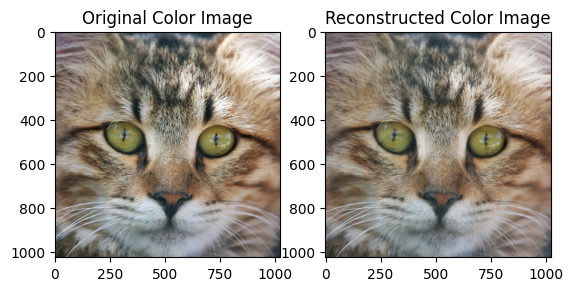

In [100]:
import numpy as np
import scipy.optimize as opt
from skimage import io
from skimage.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim

# Read the original color image
original_image = img

# Get the dimensions of the original image
image_height, image_width, num_channels = original_image.shape

# Define position encoding
def position_encoding(height, width):
    position_enc = np.zeros((height, width, num_channels))
    for i in range(height):
        for j in range(width):
            for c in range(num_channels):
                position_enc[i, j, c] = (i / height) - (j / width)
    return position_enc

# Define pixel-level difference function (mean squared error)
def pixel_difference(image, target):
    return mean_squared_error(target, image)

# Define a neural network model to adjust pixel values
class ReconstructionModel(nn.Module):
    def __init__(self, image_height, image_width, num_channels):
        super(ReconstructionModel, self).__init__()
        self.position_enc = torch.tensor(position_encoding(image_height, image_width), dtype=torch.float32)
        self.reconstructed_image = nn.Parameter(torch.randn(1, image_height, image_width, num_channels))

    def forward(self):
        return self.position_enc + self.reconstructed_image

# Initialize the neural network model
model = ReconstructionModel(image_height, image_width, num_channels)

# Define the target image (original image)
target_image = torch.tensor(original_image, dtype=torch.float32).unsqueeze(0)

# Define the pixel-level difference function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Iteratively optimize pixel values
num_epochs = 30000

# Custom symmetry loss function
def symmetry_loss(image):
    height, width = image.shape[:2]  # Only unpack height and width
    left_half = image[:, :width // 2]
    right_half = torch.flip(image[:, width // 2:], dims=[1])  # Flip the right half

    # Calculate the mean squared error between the left and right halves
    sym_loss = torch.mean((left_half - right_half) ** 2)
    return sym_loss

# Add symmetry loss to the overall loss
symmetry_weight = 1.5  # Adjust the weight as needed
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model()
    loss = criterion(outputs, target_image) + symmetry_weight * symmetry_loss(outputs)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")



# Get the optimized reconstructed image
reconstructed_image = model().detach().numpy()[0]

# Print the pixel-level difference
mse = pixel_difference(original_image, reconstructed_image)
# Save the reconstructed image
io.imsave('reconstructed_color_image.jpg', reconstructed_image.astype(np.uint8))

# If visualization is needed
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Color Image')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image.astype(np.uint8))
plt.title('Reconstructed Color Image')

plt.show()


In this program, I add a custom symmetry loss term to the existing loss function that penalizes deviations from symmetry. This loss term would compare corresponding pixel values on both sides of the image and encourage them to be similar. For example, you can calculate the mean squared difference between corresponding pixels on the left and right sides of the image.